In [31]:
import time, matplotlib, sklearn

# visualizatoin 
import matplotlib.pyplot as plt 
import seaborn as sns

# data wrangling
import pandas as pd
import numpy as np 

# data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import VarianceThreshold, f_classif, SelectFpr,SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# learning
from sklearn.linear_model import LogisticRegression

# Clustering
import lightgbm as lgb

# the data intro has been tested with the following versions
print("pandas        Tested version: 2.0.3   Your version: %s" % pd.__version__)
print("numpy         Tested version: 1.21.5  Your version: %s" % np.__version__)
print("matplotlib    Tested version: 3.5.3   Your version: %s" % matplotlib.__version__)
print("scikit-learn  Tested version: 1.2.2   Your version: %s" % sklearn.__version__)

pandas        Tested version: 2.0.3   Your version: 2.1.4
numpy         Tested version: 1.21.5  Your version: 1.24.3
matplotlib    Tested version: 3.5.3   Your version: 3.8.0
scikit-learn  Tested version: 1.2.2   Your version: 1.3.0


# Loading processed data
If you previously already have ran this code and saved the processed data as csv's you can use the following lines to open them as dataframes

In [11]:
# X_train = pd.read_csv("Data_processed/X_train.csv")
# y_train = pd.read_csv("Data_processed/y_train.csv")
# X_test = pd.read_csv("Data_processed/X_test.csv")
# y_test = pd.read_csv("Data_processed/y_test.csv")
# y_apache_train = pd.read_csv("Data_processed/y_apache_train.csv")
# y_apache_test = pd.read_csv("Data_processed/y_apache_test.csv")

# Load data
If you put the data set in the same folder as this notebook, you can use the following code to load the data set. 

In [3]:
# description
description = pd.read_csv('Data/WiDS_Datathon_2020_Dictionary.csv')
description_dict = description.set_index('Variable Name').to_dict(orient='index')
# data
df = pd.read_csv('Data/training_v2.csv')

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Columns: 186 entries, encounter_id to apache_2_bodysystem
dtypes: float64(170), int64(8), object(8)
memory usage: 130.1+ MB


In [5]:
a = df.columns.tolist()
print(a)

['encounter_id', 'patient_id', 'hospital_id', 'hospital_death', 'age', 'bmi', 'elective_surgery', 'ethnicity', 'gender', 'height', 'hospital_admit_source', 'icu_admit_source', 'icu_id', 'icu_stay_type', 'icu_type', 'pre_icu_los_days', 'readmission_status', 'weight', 'albumin_apache', 'apache_2_diagnosis', 'apache_3j_diagnosis', 'apache_post_operative', 'arf_apache', 'bilirubin_apache', 'bun_apache', 'creatinine_apache', 'fio2_apache', 'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_unable_apache', 'gcs_verbal_apache', 'glucose_apache', 'heart_rate_apache', 'hematocrit_apache', 'intubated_apache', 'map_apache', 'paco2_apache', 'paco2_for_ph_apache', 'pao2_apache', 'ph_apache', 'resprate_apache', 'sodium_apache', 'temp_apache', 'urineoutput_apache', 'ventilated_apache', 'wbc_apache', 'd1_diasbp_invasive_max', 'd1_diasbp_invasive_min', 'd1_diasbp_max', 'd1_diasbp_min', 'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_invasive_max', 'd1_

The dataset contains many different variables, including:

#### Target variable
* *hospital_death*: 'Whether the patient died during this hospitalization.

#### Identifiers
* *patient_id*: Unique identifier associated with a patient
* *encounter_id*: Unique identifier associated with a patient unit stay
* *hospital_id*: Unique identifier associated with a hospital
* *icu_id*: A unique identifier for the unit to which the patient was admitted

#### Demographics
* *age*: The age of the patient on unit admission.
* *bmi*: The body mass index of the person on unit admission.
* *ethnicity*: The common national or cultural tradition which the person belongs to.
* *gender*: The genotypical sex of the patient.
* *height*: The height of the person on unit admission

#### Health indicators
A few examples:
* *elective_surgery*: Whether the patient was admitted to the hospital for an elective surgical operation
* *h1_diasbp_invasive_max*: The patient's highest diastolic blood pressure during the first hour of their unit stay, invasively measured
* *h1_diasbp_invasive_min*: The patient's lowest diastolic blood pressure during the first hour of their unit stay, invasively measured
* *gcs_verbal_apache*: The verbal component of the Glasgow Coma Scale measured during the first 24 hours which results in the highest APACHE III score
* *immunosuppression*: Whether the patient has their immune system suppressed within six months prior to ICU admission for any of the following reasons; radiation therapy, chemotherapy, use of non-cytotoxic immunosuppressive drugs, high dose steroids (at least 0.3 mg/kg/day of methylprednisolone or equivalent for at least 6 months).

In [56]:
# you can retrieve the description of a variable in the data set from the description dictionary as follows
description_dict['temp_apache']

{'Category': 'APACHE covariate',
 'Unit of Measure': 'Degrees Celsius',
 'Data Type': 'numeric',
 'Description': 'The temperature measured during the first 24 hours which results in the highest APACHE III score',
 'Example': '33'}

# Data Exploration

In [47]:
rows_with_missing_data = df.isnull().any(axis=1).sum()

print("The total number of rows: 91713")
print("Out of those rows, this many contain missing data:", rows_with_missing_data)
print("So that is a percentage of:", (rows_with_missing_data / 91713)*100)

The total number of rows: 91713
Out of those rows, this many contain missing data: 91688
So that is a percentage of: 99.97274105088701


In [61]:
categorical_column_count = 0

for column in df.columns:
    if df[column].dtype == 'object' or pd.api.types.is_categorical_dtype(df[column]):
        categorical_column_count += 1

print("Number of categorical columns:", categorical_column_count)

Number of categorical columns: 8


C:\Users\20224022\AppData\Local\Temp\ipykernel_18052\3624830847.py:4: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if df[column].dtype == 'object' or pd.api.types.is_categorical_dtype(df[column]):


In [54]:
all = list(df.columns)
print(all)

['encounter_id', 'patient_id', 'hospital_id', 'hospital_death', 'age', 'bmi', 'elective_surgery', 'ethnicity', 'gender', 'height', 'hospital_admit_source', 'icu_admit_source', 'icu_id', 'icu_stay_type', 'icu_type', 'pre_icu_los_days', 'readmission_status', 'weight', 'albumin_apache', 'apache_2_diagnosis', 'apache_3j_diagnosis', 'apache_post_operative', 'arf_apache', 'bilirubin_apache', 'bun_apache', 'creatinine_apache', 'fio2_apache', 'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_unable_apache', 'gcs_verbal_apache', 'glucose_apache', 'heart_rate_apache', 'hematocrit_apache', 'intubated_apache', 'map_apache', 'paco2_apache', 'paco2_for_ph_apache', 'pao2_apache', 'ph_apache', 'resprate_apache', 'sodium_apache', 'temp_apache', 'urineoutput_apache', 'ventilated_apache', 'wbc_apache', 'd1_diasbp_invasive_max', 'd1_diasbp_invasive_min', 'd1_diasbp_max', 'd1_diasbp_min', 'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_invasive_max', 'd1_

In [60]:
df['age'].mean()
df['bmi'].median()

27.65465458

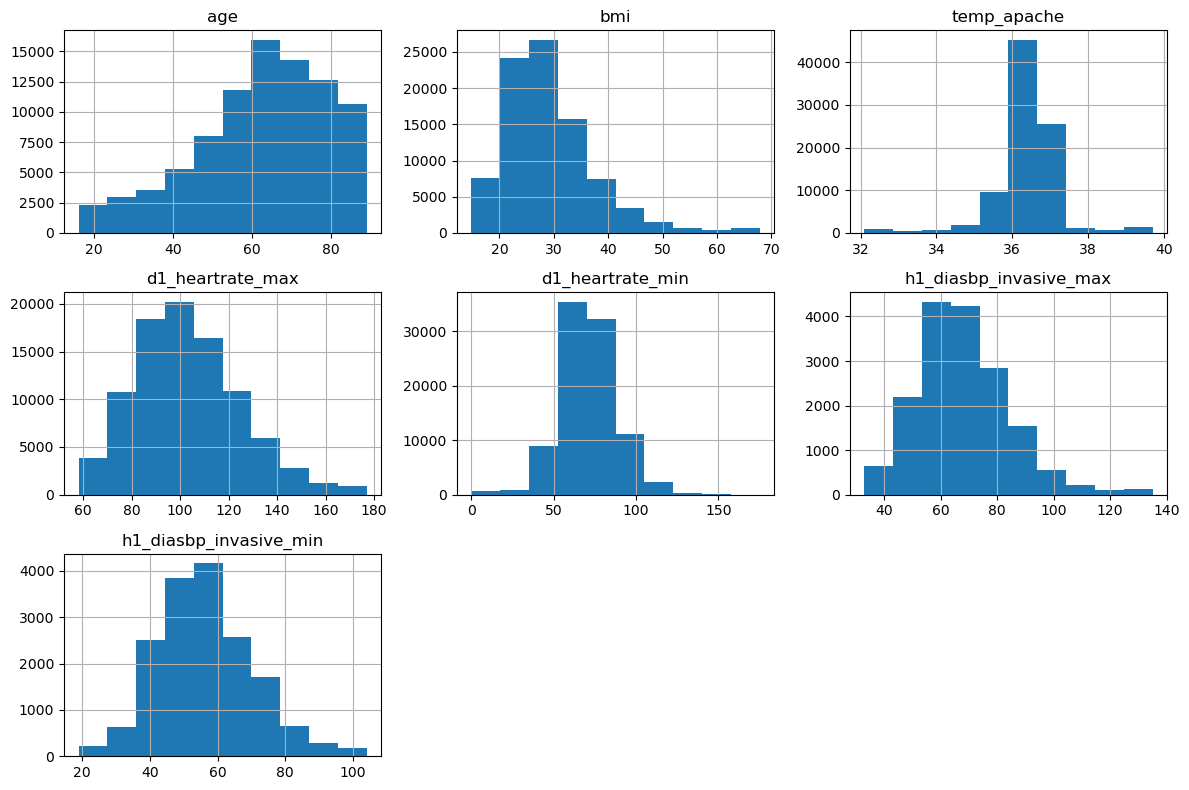

C:\Users\20224022\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\20224022\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\20224022\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\20224022\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

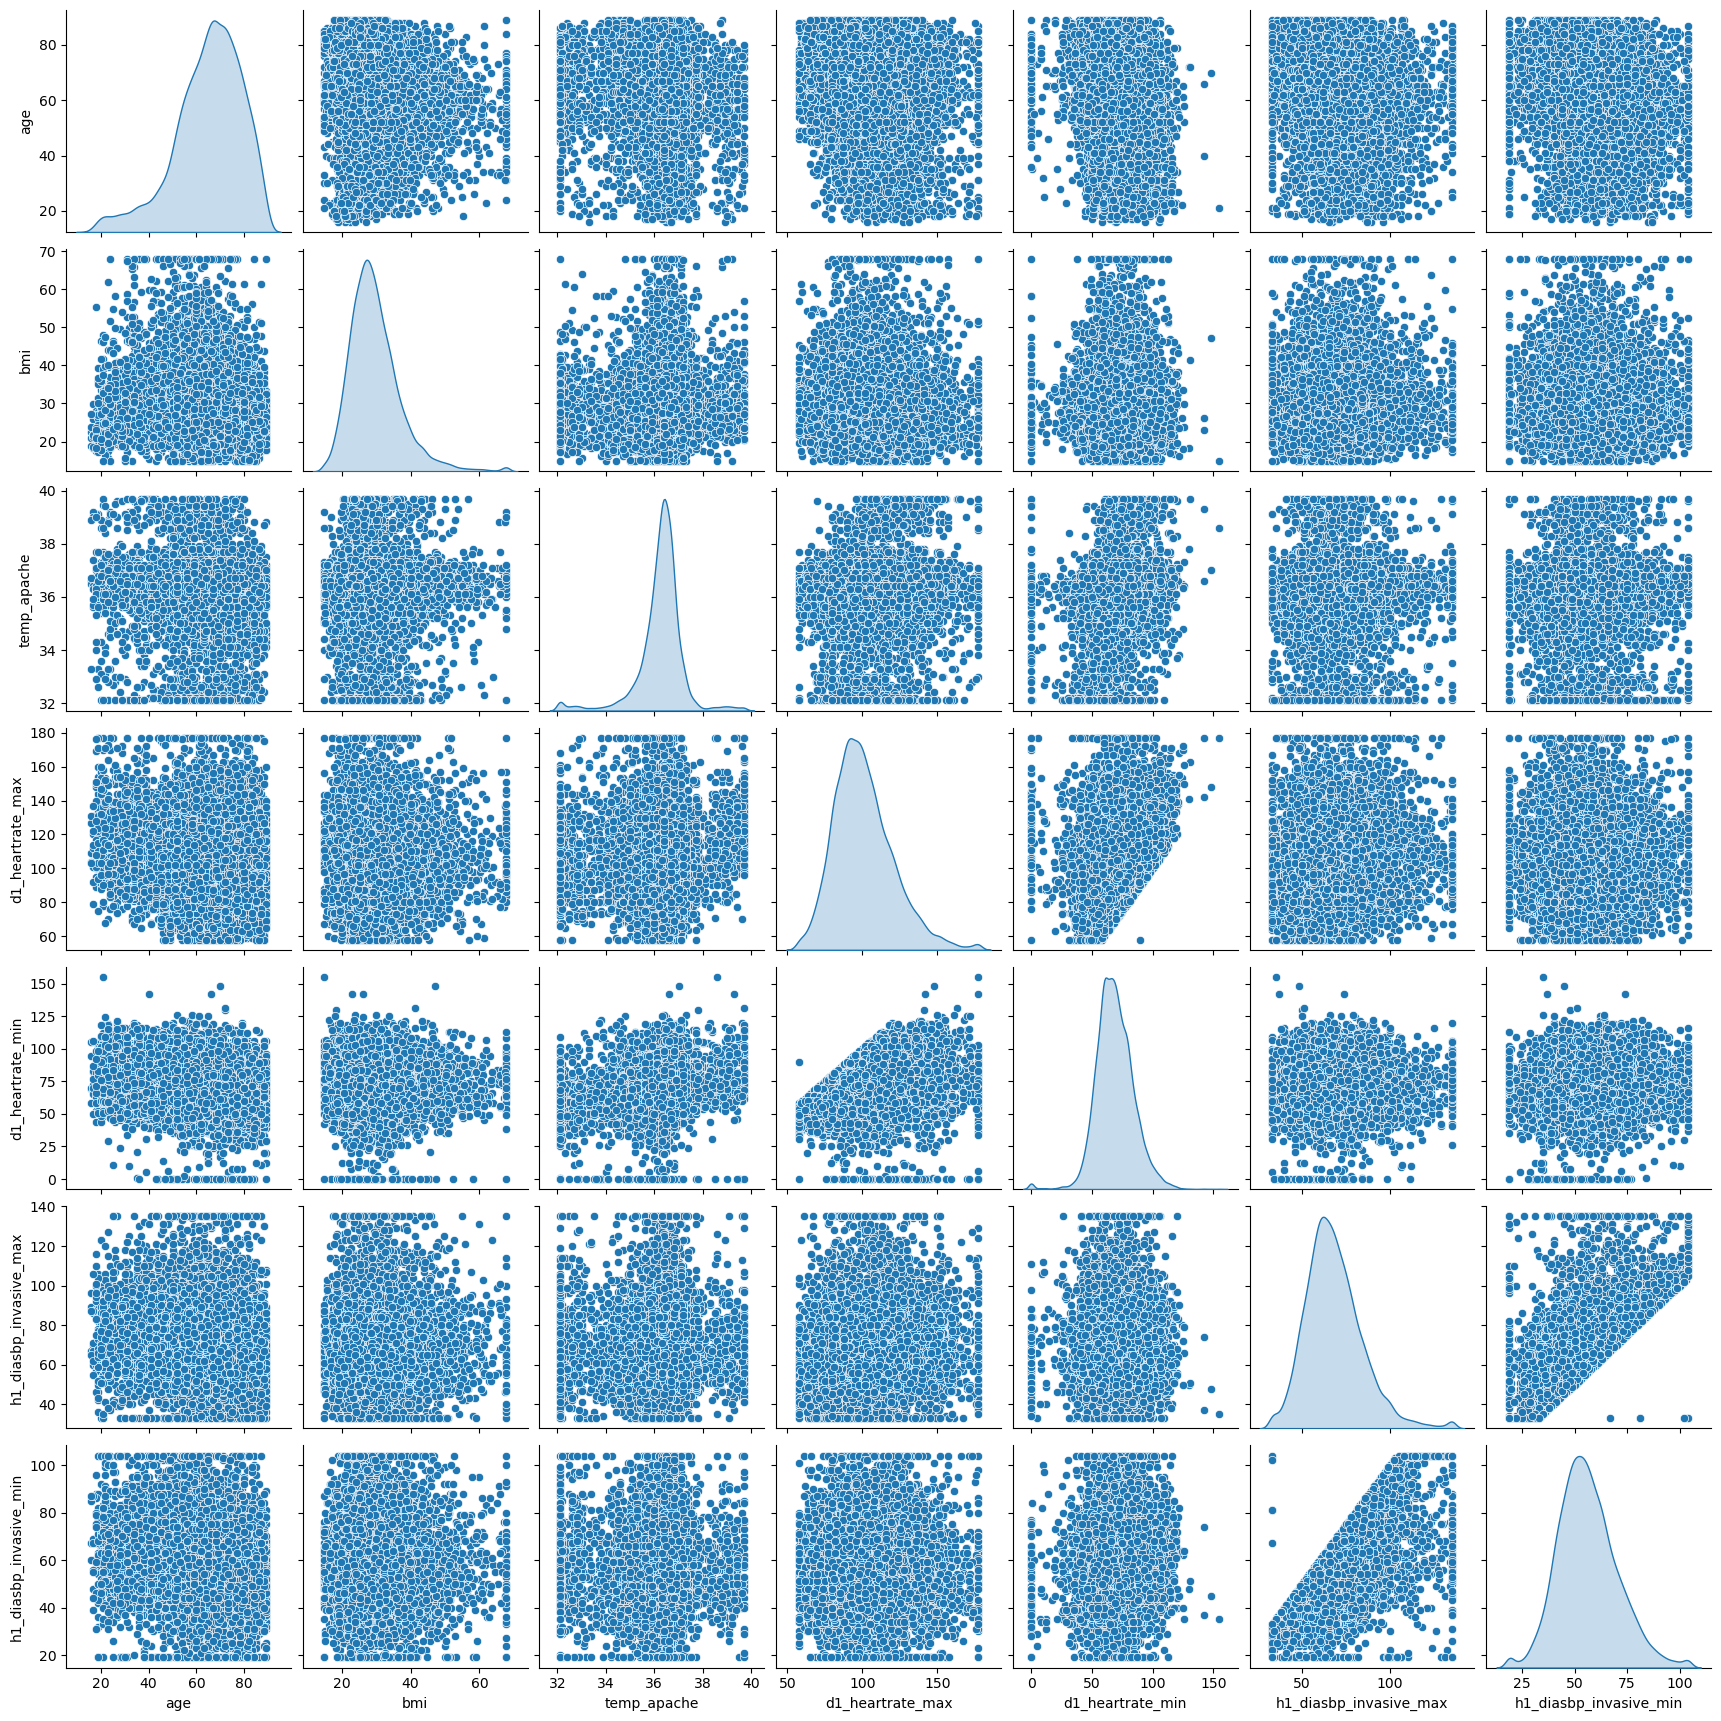

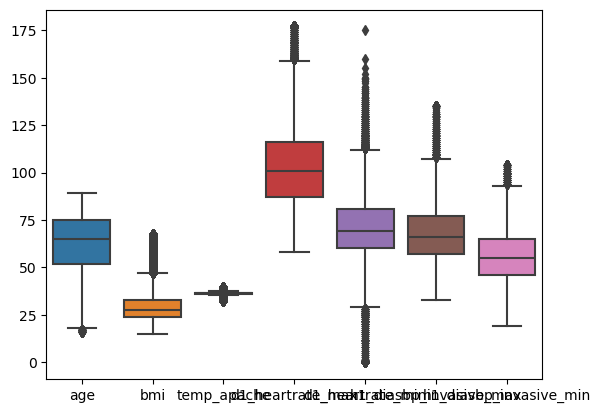

ValueError: could not convert string to float: 'M'

In [57]:
# columns that we ended up selecting
selected_columns = ['age', 'gender', 'ethnicity', 'bmi', 'temp_apache', 'd1_heartrate_max', 'd1_heartrate_min', 'h1_diasbp_invasive_max', 'h1_diasbp_invasive_min']

# Data Distribution

df[selected_columns].hist(figsize=(12, 8))
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

sns.pairplot(df[selected_columns].dropna(), diag_kind='kde')
plt.show()

sns.boxplot(data=df[selected_columns])
plt.show()

# Pairwise Correlations

selected_corr_matrix = df[selected_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(selected_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Pairwise Correlation Matrix (Selected Columns)')
plt.show()

# Pre-processing
This is a real-world data set, meaning that it is **messy**. Two key difficulties are categorial features and missing values.

> **To avoid information leakage, any pre-processing steps must be based on the training data only.** For example, when we compute the mean, this must be computed based on the training data set.

### Categorical Features
Many (implementations of) machine learning algorithms cannot handle categorical features automatically. This is often dealt with through *one-hot-encoding*, where each category of a feature is transformed into a binary feature.

When a feature contains many categories, this results in a very sparse data set with many features. As such, it can be worthwile to use domain expertise to merge particular categories in order to reduce the number of one-hot-encoded features.

### Missing Values
The data set contains a lot of missing values (around 35% of the values is missing). There are several ways to deal with this, some ideas to try:

* Replace missing values with the mean (numerical features) or median (categorical features), e.g., using [`SimpleImputer`](https://scikit-learn.org/stable/modules/impute.html#univariate-feature-imputation).
* Drop features with many missing values.
* Model-based imputation strategies, such as [KNNImputer](https://scikit-learn.org/stable/modules/impute.html#nearest-neighbors-imputation).
* Domain-knowledge inspired replacement. For example, for features related to medical measurements, it is expected that the entered data is abnormal in some way. As such, replacing by the mean or median can paint a skewed picture. One way to deal with this would be to identify a normal range for different measurements, based on domain expertise. *Note: this is a very time consuming strategy which we do not necessarily recommend in the time span of this project.*

We encourage you to try several approaches and see what works best.

## Example of  Minimal Pre-Processing
Below you can find an example of pre-processing the data set for classification. We showcase both 'manual' pre-processing steps through `pandas` as well as a (small) scikit-learn `Pipeline`. Feel free to use whatever you are most comfortable with in your project.

In [16]:
test_size = 0.2 # proportion for train versus test+val split
val_size = 0.5 # proportion for test versus val split
random_state = 42  # random state is used to set a seed for randomness, which is only relevant for reproducibility purposes
max_missing = 0.5  # maximum percentage of missing values for a column to be dropped

In [17]:
start_time = time.time()

# save features
X = df.copy().drop(['hospital_death', 'patient_id', 'encounter_id', 'hospital_id', 'icu_id', # drop identifiers
                    'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob', # drop APACHE scores
                    'apache_2_bodysystem'], # drop because of similarity with apache_3j_bodysystem
                   axis=1)

# save target variable
y = df['hospital_death'].copy()
# save APACHE scores for later evaluation on train / test / validation data
y_apache = df['apache_4a_hospital_death_prob'].copy()

""" SPLIT DATA SET """
# split the dataset into train and test+validation set
(
    X_train,
    X_test,
    y_train,
    y_test,
    y_apache_train,
    y_apache_test,
    ) = train_test_split(X, y, y_apache, 
                         test_size=test_size, # used for testing and validation
                         random_state=random_state # for reproducibility
                        ) 
# split the test set into test + validation set
(
    X_val,
    X_test,
    y_val,
    y_test,
    y_apache_val,
    y_apache_test,
    ) = train_test_split(X_test, y_test, y_apache_test, 
                         test_size=val_size, # used for testing and validation
                         random_state=random_state # for reproducibility
                        ) 

"""MISSING VALUES"""
# drop columns with many missing values
missing = X_train.isna().sum() > max_missing * len(X_train) 
missing = missing[missing].index
X_train = X_train.drop(missing, axis=1)
X_val = X_val.drop(missing, axis=1)
X_test = X_test.drop(missing, axis=1)

"""FURTHER PROCESSING PIPELINE"""
# use iterativeimputer
num_transformer = Pipeline(steps=[
    ("constant", VarianceThreshold()),  # remove the constant features
    ("imputer", IterativeImputer(max_iter = 15, tol = 0.001, random_state=random_state)),
])

cat_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(drop='first', sparse_output=False, handle_unknown="ignore"))
])

# create preprocessing pipeline
prep_pipeline = ColumnTransformer(
    transformers=[
        ('num', num_transformer, make_column_selector(dtype_exclude=object)),  # apply to columns NOT of type object (int or float)
        ('cat', cat_transformer, make_column_selector(dtype_include=object))   # apply to columns of type object
    ]
)

# pipeline
prep_pipeline.fit(X_train, y_train)
display(prep_pipeline) # disply preprocessing pipeline

# transform data sets
X_train = pd.DataFrame(prep_pipeline.transform(X_train), columns=prep_pipeline.get_feature_names_out())
X_val = pd.DataFrame(prep_pipeline.transform(X_val), columns=prep_pipeline.get_feature_names_out())
X_test = pd.DataFrame(prep_pipeline.transform(X_test), columns=prep_pipeline.get_feature_names_out())
        
"""PRINT STATS"""
print("Time: %.2fs" % (time.time() - start_time))
print("Train set: %s rows, %s columns" % X_train.shape)
print("Validation set: %s rows, %s columns" % X_val.shape)
print("Test set: %s rows, %s columns" % X_test.shape)

C:\Users\20224022\AppData\Local\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('constant',
                                                  VarianceThreshold()),
                                                 ('imputer',
                                                  IterativeImputer(max_iter=15,
                                                                   random_state=42))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000002228DD63890>),
                                ('cat',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000022282602990>)])

Time: 1004.34s
Train set: 73370 rows, 144 columns
Validation set: 9171 rows, 144 columns
Test set: 9172 rows, 144 columns


In [9]:
# X_train.to_csv("X_train.csv")
# y_train.to_csv("y_train.csv")
# X_test.to_csv("X_test.csv")
# y_test.to_csv("y_test.csv")
# y_apache_train.to_csv("y_apache_train.csv")
# y_apache_test.to_csv("y_apache_test.csv")

In [62]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73370 entries, 0 to 73369
Columns: 144 entries, num__age to cat__apache_3j_bodysystem_nan
dtypes: float64(144)
memory usage: 80.6 MB


## Simple Logistic Regression Model
We can now train a simple logistic regression model.

> **Warning**. The following code will lead to a convergence warning. To solve this "issue", you can increase `max_iter` and/or apply a `sklearn.preprocessing.StandardScaler()`. However, the model still performance reasonably well even without convergence.

In [18]:
start_time = time.time()

# train logistic regression model
lr = LogisticRegression(penalty='l1', solver='saga')
lr.fit(X_train, y_train)

print("Time: %.2fs" % (time.time() - start_time))

Time: 45.75s


C:\Users\20224022\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


# APACHE IV Scores
APACHE ("Acute Physiology and Chronic Health Evaluation") is a scoring system assessing severity of illness and prognoses of ICU patients. The scoring system has been improved over time, with APACHE II being released in 1985, APACHE III in 1991, and finally APACHE IV in 2006. APACHE IV has been evaluated and validated in patients for mortality outcome. 

In the dataset, the *apache_4a_hospital_death_prob* column corresponds to the APACHE IV probabilistic prediction of in-hospital mortality for the patient which utilizes the APACHE III score and other covariates, including diagnosis.
* `-1` means the score couldn't be calculated for some reason. In particular, the patient encounter could have been a re-admission. 
* `NaN` indicates a missing score, due to e.g., a missing covariate that made it impossible to compute the score. 


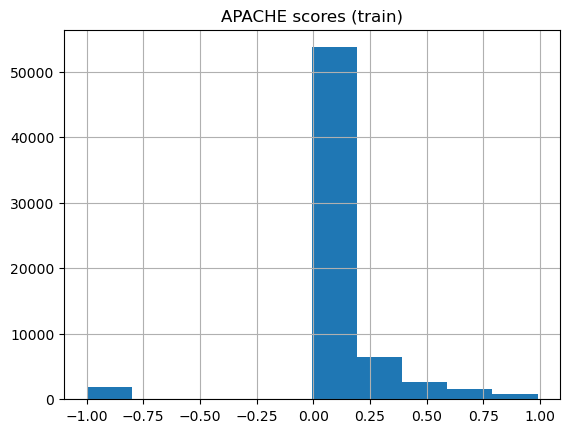

In [19]:
# histogram
y_apache_train.hist()
plt.title("APACHE scores (train)")
plt.show()

# Choosing columns to work with

In [20]:
model = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)
model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],
          eval_metric='logloss')

print('Training accuracy {:.4f}'.format(model.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(model.score(X_test,y_test)))

C:\Users\20224022\AppData\Local\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\20224022\AppData\Local\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 6328, number of negative: 67042
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20625
[LightGBM] [Info] Number of data points in the train set: 73370, number of used features: 141
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.086248 -> initscore=-2.360335
[LightGBM] [Info] Start training from score -2.360335
Training accuracy 0.9433
Testing accuracy 0.9285


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

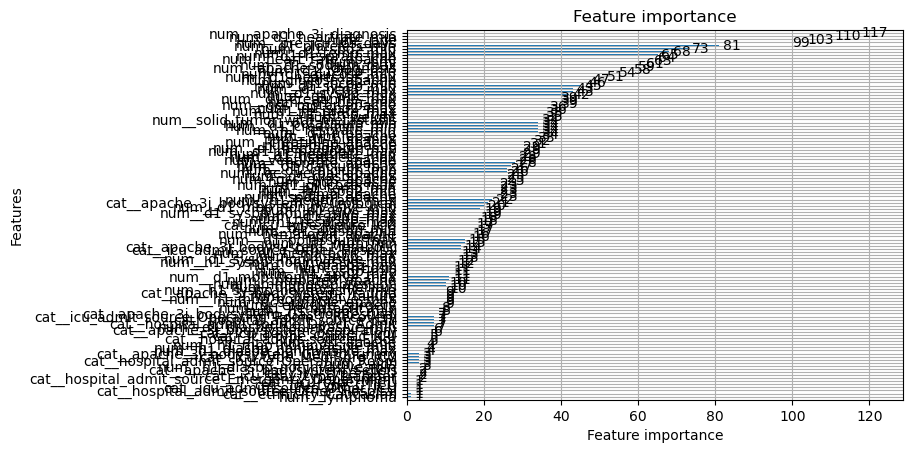

In [21]:
# plot showing the importance of all the features in the dataset
lgb.plot_importance(model)

Text(0.5, 1.0, 'Anova')

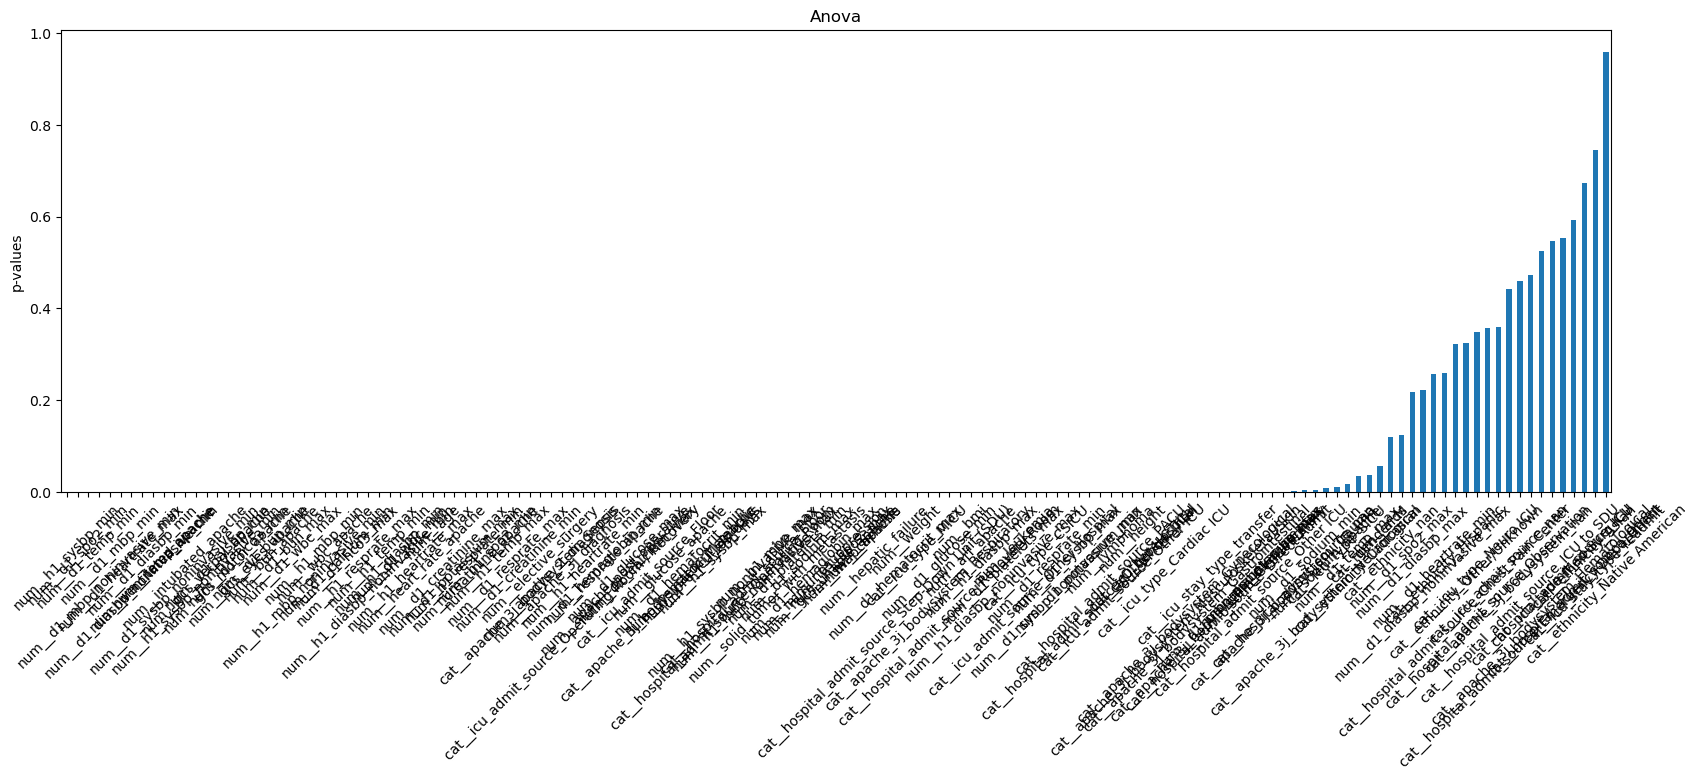

In [22]:
# feature selection using ANOVA

univariate = f_classif(X_train, y_train)

univariate = pd.Series(univariate[1])
univariate.index = X_train.columns
univariate.sort_values(ascending=True).plot.bar(figsize=(20, 6), rot=45)
plt.ylabel("p-values")
plt.title("Anova")

In [25]:
sel = SelectFpr(f_classif, alpha=0.005).fit(X_train, y_train)
X_train.columns[sel.get_support()]

selected_features = X_train.columns[sel.get_support()]
X_train_selected = X_train[selected_features]
X_train_selected

,num__age,num__bmi,num__elective_surgery,num__height,num__pre_icu_los_days,num__weight,num__apache_2_diagnosis,num__apache_3j_diagnosis,num__apache_post_operative,num__arf_apache,...,cat__icu_type_MICU,cat__apache_3j_bodysystem_Gastrointestinal,cat__apache_3j_bodysystem_Genitourinary,cat__apache_3j_bodysystem_Gynecological,cat__apache_3j_bodysystem_Metabolic,cat__apache_3j_bodysystem_Musculoskeletal/Skin,cat__apache_3j_bodysystem_Neurological,cat__apache_3j_bodysystem_Respiratory,cat__apache_3j_bodysystem_Sepsis,cat__apache_3j_bodysystem_Trauma
0,86.000000,28.168975,0.0,170.2,0.000000,81.6,301.000000,408.020000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,72.000000,36.635088,0.0,170.1,0.088889,106.0,124.000000,305.010000,0.0,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,36.000000,27.459684,0.0,162.6,0.044444,72.6,122.000000,703.030000,0.0,0.000000,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,60.000000,21.977351,0.0,181.0,0.213194,72.0,305.000000,901.030000,0.0,0.000000,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,27.000000,19.960244,0.0,177.8,0.052083,63.1,113.000000,501.040000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73365,16.000000,22.378743,1.0,165.1,0.004167,61.0,219.000000,1504.040000,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
73366,70.000000,29.475309,1.0,180.0,0.560417,95.5,180.361333,0.250000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73367,72.000000,30.827304,1.0,187.0,0.236806,107.8,202.000000,1205.010000,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73368,46.000000,61.339079,0.0,167.6,0.000000,172.3,102.000000,206.010000,0.0,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [26]:
# printing the features sorted from highest to lowest importance
feature_scores = sel.scores_

feature_scores_dict = {feature: score for feature, score in zip(selected_features, feature_scores)}
sorted_features = sorted(feature_scores_dict.items(), key=lambda x: x[1], reverse=True)

for feature, score in sorted_features:
    print(f"{feature}: {score}")

num__gcs_motor_apache: 6525.123155794183
num__gcs_eyes_apache: 5418.854289020089
num__gcs_verbal_apache: 4576.8143191122135
num__wbc_apache: 4033.8434676119205
num__h1_diasbp_min: 3390.874863119123
num__h1_diasbp_noninvasive_min: 3381.447576857179
num__d1_temp_min: 3328.9652029591466
num__h1_heartrate_min: 3250.203914410504
num__d1_resprate_min: 2891.468462701851
num__d1_sysbp_max: 2872.3441396389685
num__d1_glucose_max: 2444.440758155425
num__d1_heartrate_max: 2405.1102738829936
num__bun_apache: 2395.9819225762167
num__d1_mbp_min: 2395.5075467324687
num__d1_glucose_min: 2337.892253650326
num__intubated_apache: 2296.823853354796
num__d1_mbp_noninvasive_max: 2121.325020622661
num__d1_platelets_min: 1951.325309561622
num__ventilated_apache: 1912.0583487535785
num__d1_bun_min: 1535.5002484261754
num__d1_calcium_min: 1531.6529897042758
num__leukemia: 1466.6492081041897
num__h1_sysbp_min: 1418.3341071269876
num__h1_spo2_min: 1401.916742703803
num__d1_diasbp_min: 1332.302568529755
num__d1_hc

In [29]:
df_features = pd.DataFrame(sorted_features, columns=['Feature', 'Score'])

df_imp_feat = df_features.iloc[0:9]  # in here you can spcify how many features you want to select
imp_feat_lst = df_imp_feat['Feature'].tolist()
imp_feat_lst

['num__gcs_motor_apache',
 'num__gcs_eyes_apache',
 'num__gcs_verbal_apache',
 'num__wbc_apache',
 'num__h1_diasbp_min',
 'num__h1_diasbp_noninvasive_min',
 'num__d1_temp_min',
 'num__h1_heartrate_min',
 'num__d1_resprate_min']

In [30]:
df_split = X_train[imp_feat_lst]
df_split['hospital_death'] = y_train
df_split.corr()

C:\Users\20224022\AppData\Local\Temp\ipykernel_18052\3033822872.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_split['hospital_death'] = y_train


,num__gcs_motor_apache,num__gcs_eyes_apache,num__gcs_verbal_apache,num__wbc_apache,num__h1_diasbp_min,num__h1_diasbp_noninvasive_min,num__d1_temp_min,num__h1_heartrate_min,num__d1_resprate_min,hospital_death
num__gcs_motor_apache,1.000000,0.801635,0.701938,-0.119051,0.073452,0.073472,0.265499,-0.045324,0.059078,-0.000733
num__gcs_eyes_apache,0.801635,1.000000,0.781087,-0.119002,0.084914,0.084387,0.218215,-0.048236,0.071928,-0.001265
num__gcs_verbal_apache,0.701938,0.781087,1.000000,-0.132343,0.095529,0.094279,0.189156,-0.068482,0.055830,-0.000716
num__wbc_apache,-0.119051,-0.119002,-0.132343,1.000000,-0.109642,-0.109242,-0.061743,0.159440,0.029519,0.000069
num__h1_diasbp_min,0.073452,0.084914,0.095529,-0.109642,1.000000,0.981435,0.083003,0.111280,0.079412,0.003527
num__h1_diasbp_noninvasive_min,0.073472,0.084387,0.094279,-0.109242,0.981435,1.000000,0.081089,0.111459,0.076444,0.003644
num__d1_temp_min,0.265499,0.218215,0.189156,-0.061743,0.083003,0.081089,1.000000,0.097934,0.107333,0.003393
num__h1_heartrate_min,-0.045324,-0.048236,-0.068482,0.159440,0.111280,0.111459,0.097934,1.000000,0.182839,0.007332
num__d1_resprate_min,0.059078,0.071928,0.055830,0.029519,0.079412,0.076444,0.107333,0.182839,1.000000,-0.005357
hospital_death,-0.000733,-0.001265,-0.000716,0.000069,0.003527,0.003644,0.003393,0.007332,-0.005357,1.000000


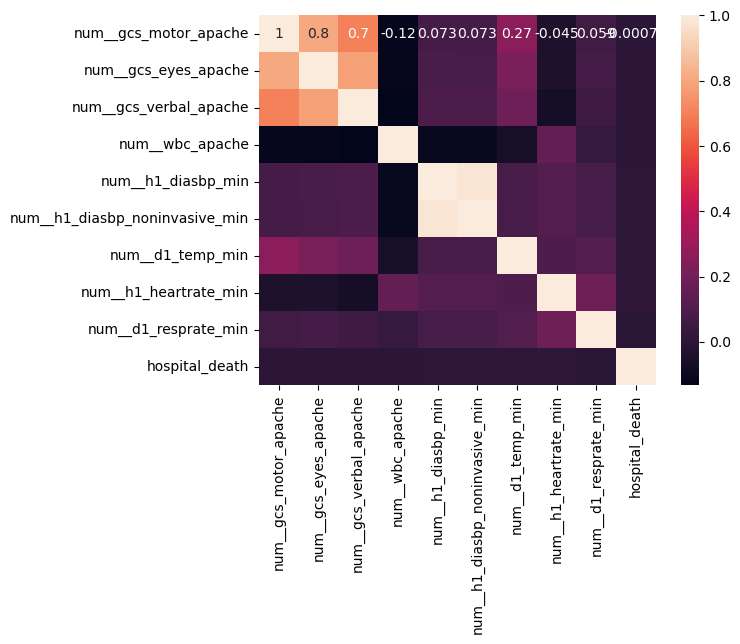

In [32]:
corr_matrix = df_split.corr()

sns.heatmap(corr_matrix, annot=True)
plt.show()

In [33]:
correlation_list = corr_matrix.unstack().sort_values(ascending=False)
correlation_list_filtered = correlation_list[correlation_list != 1]

correlation_list_filtered[:20]

num__h1_diasbp_min              num__h1_diasbp_noninvasive_min    0.981435
num__h1_diasbp_noninvasive_min  num__h1_diasbp_min                0.981435
num__gcs_eyes_apache            num__gcs_motor_apache             0.801635
num__gcs_motor_apache           num__gcs_eyes_apache              0.801635
num__gcs_verbal_apache          num__gcs_eyes_apache              0.781087
num__gcs_eyes_apache            num__gcs_verbal_apache            0.781087
num__gcs_motor_apache           num__gcs_verbal_apache            0.701938
num__gcs_verbal_apache          num__gcs_motor_apache             0.701938
num__gcs_motor_apache           num__d1_temp_min                  0.265499
num__d1_temp_min                num__gcs_motor_apache             0.265499
num__gcs_eyes_apache            num__d1_temp_min                  0.218215
num__d1_temp_min                num__gcs_eyes_apache              0.218215
                                num__gcs_verbal_apache            0.189156
num__gcs_verbal_apache   